In [29]:
import pandas as pd
import numpy as np
from sodapy import Socrata
from varname import nameof
from datetime import datetime
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay


from sklearn.feature_extraction import DictVectorizer
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import holidays
import pickle
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew

In [42]:
def get_data(state: str, year: tuple):
    query = f"""
    select 
    * 
    where 
    yr IN {year}
    and boro = 'Staten Island'
    
    limit
    1000000
    """
    client = Socrata("data.cityofnewyork.us", "3n6p17M38sFlzBvS1cnosPxah")
    client.timeout = 100000

    results = client.get("7ym2-wayt",  query=query)
    results_df = pd.DataFrame.from_records(results)   # Convert to pandas DataFrame
    return results_df


def analyse_data(df: pd.DataFrame, target_col: str):
    print("The size of the data is: ", df.shape)
    return None

def preprocess_data_1(df: pd.DataFrame):
    """Groupy by hour to generatehourly traffic flow and create a date_time variable 
    from the time_related columns

    Args:
        df (pd.DataFrame): The main dataframe set

    Returns:
        df: Preprocessed data fram
    """

    # convert the target volume to interger
    df['vol'] = df['vol'].astype(int)

    # aggregate by segment for each daily hr
    df = df.groupby(['segmentid','yr', 'm','d','hh','street']).sum().reset_index().copy()  

    # convert to datetime for datetime processing
    for col in ['m', 'd', 'hh']:
        df[col] = df[col].str.zfill(2)
    df['date_time'] = pd.to_datetime( df['yr']+df['m']+df['d']+(df['hh']),
                                      format='%Y%m%d%H', 
                                      errors='raise' )
    return df

def preprocess_data_2(df: pd.DataFrame, dv:DictVectorizer, fit_dv: bool=False):

    # everything is categorical for now
    categorical_col = ['segmentid','m','d','hh', 'street','week_number', 'quarter', 'week_day','holiday_check']
    # categorical_col = ['hh']

    df[categorical_col] =  df[categorical_col].astype('str')

    train_dicts = df[categorical_col].to_dict(orient='records')

    if fit_dv:
        X = dv.fit_transform(train_dicts)
    else:
        X = dv.transform(train_dicts)
    return X, dv

def ft_engineering(df: pd.DataFrame):

    # feature engineering for date time which includes
    df['week_number'] = df['date_time'].dt.isocalendar().week
    df['quarter'] = df['date_time'].dt.quarter
    df['week_day'] = df['date_time'].dt.weekday

    # holdays 
    US_hols = holidays.US(years=range(2010, 2025, 1))
    df['holiday_check'] = df.date_time.apply(lambda x: x in US_hols)
    return df

def dump_pickle(obj, filename):

    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)

def convert_to_parquet(df: pd.DataFrame, dest_path: str):
    df.to_parquet( dest_path, engine='pyarrow',compression=None,index= False)


def read_downloaded_data(file_path: str, save_to_local=False):
    
    # run to download the data online
    df_train = get_data(state='Staten Island', year=(2011,2012,2013))
    df_valid = get_data(state='Staten Island', year=(2014,2015,2016))
    df_test= get_data(state='Staten Island', year=(2017,2018))

    if save_to_local==True:
        # run this code to convert the data to parquet to avoid hitting the API everytime since the data is static.
        convert_to_parquet(df_train, '../data/train.parquet')
        convert_to_parquet(df_test, '../data/test.parquet')
        convert_to_parquet(df_valid, '../data/valid.parquet')


def print_metrics(model, X, Y):
    # Evaluate the data 
    y_pred= model.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    print(rmse)

def run():
    return None

In [20]:
# run to download the data online

# df_train = get_data(state='Staten Island', year=(2011,2012,2013))
# df_valid = get_data(state='Staten Island', year=(2014,2015,2016))
# df_test= get_data(state='Staten Island', year=(2017,2018))

# After run to convert to parquet file format
# run this code to convert the data to parquet to avoid hitting the API everytime since the data is static.
# convert_to_parquet(df_train, '../data/train.parquet')
# convert_to_parquet(df_test, '../data/test.parquet')
# convert_to_parquet(df_valid, '../data/valid.parquet')

### Run Process

In [21]:
# read parquet file
df_train = pd.read_parquet("../data/train.parquet")
df_test = pd.read_parquet("../data/test.parquet")
df_valid = pd.read_parquet("../data/valid.parquet")

In [34]:
# 1st do cursory look at the data
# Data Wrangling of the Data
print(df_train.shape, df_valid.shape, df_test.shape)
# df_train.info()

(100892, 12) (97841, 12) (30758, 12)


In [23]:
df_train = ft_engineering(preprocess_data_1(df_train))
df_test = ft_engineering(preprocess_data_1(df_test))
df_valid = ft_engineering(preprocess_data_1(df_valid))

dv = DictVectorizer()
X_train, dv = preprocess_data_2(df_train, dv, fit_dv=True)
X_valid, _ = preprocess_data_2(df_valid, dv, fit_dv=False)
X_test, _ = preprocess_data_2(df_test, dv, fit_dv=False)

Y_train = df_train['vol'].values
Y_test = df_test['vol'].values
Y_valid = df_valid['vol'].values

In [24]:
df_train.shape, df_valid.shape, df_test.shape

((100892, 12), (97841, 12), (30758, 12))

In [25]:
df_train

,segmentid,yr,m,d,hh,street,vol,date_time,week_number,quarter,week_day,holiday_check
0,10043,2011,05,10,00,PORT RICHMOND AVE BET CASTLETON & HARRISON AVES,25,2011-05-10 00:00:00,19,2,1,False
1,10043,2011,05,10,00,PRT RICHMOND AVE BET CASTLETON & HARRISON AVES,28,2011-05-10 00:00:00,19,2,1,False
2,10043,2011,05,10,01,PORT RICHMOND AVE BET CASTLETON & HARRISON AVES,22,2011-05-10 01:00:00,19,2,1,False
3,10043,2011,05,10,01,PRT RICHMOND AVE BET CASTLETON & HARRISON AVES,16,2011-05-10 01:00:00,19,2,1,False
4,10043,2011,05,10,10,PORT RICHMOND AVE BET CASTLETON & HARRISON AVES,153,2011-05-10 10:00:00,19,2,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
100887,9995,2013,03,22,03,CASTLETON AV,28,2013-03-22 03:00:00,12,1,4,False
100888,9995,2013,03,22,04,CASTLETON AV,31,2013-03-22 04:00:00,12,1,4,False
100889,9995,2013,03,22,05,CASTLETON AV,52,2013-03-22 05:00:00,12,1,4,False
100890,9995,2013,03,22,06,CASTLETON AV,119,2013-03-22 06:00:00,12,1,4,False


In [26]:
# build model
# train model and set parameters
# evaluate the model
params ={
    'objective':'reg:squarederror',
    'learning_rate': 0.05,
    "eval_metric": "rmse",
    "seed": 2022,
    "max_depth": 10,
}

train = xgb.DMatrix(X_train, label =Y_train)
test = xgb.DMatrix(X_test, label = Y_test)
valid = xgb.DMatrix(X_valid, label = Y_valid)



# train the model
xgb_model = xgb.train(params, dtrain=train,evals=[(valid, 'val')], num_boost_round =1000, early_stopping_rounds=100)

[0]	val-rmse:751.34192
[1]	val-rmse:744.27417
[2]	val-rmse:737.50458
[3]	val-rmse:731.48950
[4]	val-rmse:724.84998
[5]	val-rmse:719.70471
[6]	val-rmse:714.11407
[7]	val-rmse:709.51471
[8]	val-rmse:704.83929
[9]	val-rmse:700.11127
[10]	val-rmse:696.47778
[11]	val-rmse:691.06146
[12]	val-rmse:687.95245
[13]	val-rmse:683.86566
[14]	val-rmse:680.98749
[15]	val-rmse:677.23969
[16]	val-rmse:675.12183
[17]	val-rmse:671.13623
[18]	val-rmse:667.88007
[19]	val-rmse:666.22455
[20]	val-rmse:664.60553
[21]	val-rmse:660.99213
[22]	val-rmse:659.58643
[23]	val-rmse:656.39343
[24]	val-rmse:653.63092
[25]	val-rmse:652.32172
[26]	val-rmse:649.63989
[27]	val-rmse:647.36072
[28]	val-rmse:645.18658
[29]	val-rmse:643.97711
[30]	val-rmse:641.27801
[31]	val-rmse:640.81500
[32]	val-rmse:638.90802
[33]	val-rmse:637.33502
[34]	val-rmse:636.58948
[35]	val-rmse:634.89246
[36]	val-rmse:634.56445
[37]	val-rmse:633.08716
[38]	val-rmse:632.77960
[39]	val-rmse:630.98438
[40]	val-rmse:630.27539
[41]	val-rmse:629.00244
[4

<AxesSubplot:ylabel='Count'>

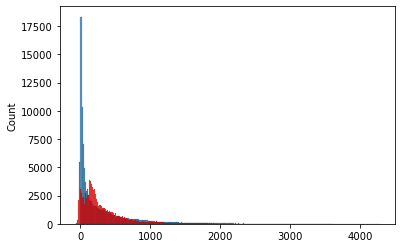

In [27]:
sns.histplot(Y_train)
sns.histplot(xgb_model.predict(train),color='red')

<AxesSubplot:ylabel='Count'>

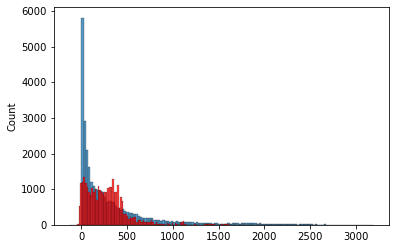

In [28]:
sns.histplot(Y_test)
sns.histplot(xgb_model.predict(test),color='red')

In [43]:
print_metrics(xgb_model, test, Y_test)

407.0613785255132


In [44]:
import mlflow
BACKEND_STORE = "sqlite3:///../experiment_tracking_log/mlflow.db"

mlflow.set_tracking_uri(BACKEND_STORE)  #change for use in cloud platform
mlflow.set_experiment("Traffic_Count_MLOPS_Project")

AttributeError: module 'mlflow' has no attribute 'set_tracking_url'